# Solving stochastic optimization problems

Stochastic optimization deals with problems whose fitness function is stochastic rather than deterministic. 

Formally we seek to minimize the expected value of some quantity:

$$
f(\mathbf x) = \mathbb{E}_{\mathbf w} f(\mathbf x,\mathbf w)
$$

In stochastic optimization, the expected value is often approximated (stochastic sample average, SSA) with the average over a sample of size $s$, so that our optimization problem becomes:

$$
f(\mathbf x) = \sum_{j=1}^s f(\mathbf x,\mathbf w_j)
$$

where $s$ samples of our stochastic variable have been generated upfront. Clearly for $s\rightarrow \infty$ the SSA approximation becomes exact. Ideally we would want an algorithm to be able to solve the optimization problem without using infinite samples. 

This tutorial shows the use of pygmo in such cases. 


In [2]:
import pygmo as pg
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from time import time
%matplotlib inline

As an example of a stochastic optimization problem, we use a simple case:

$$
f(\mathbf x, w) = \left(\sum_{i}^{d} x_i^{2}\right)^{\frac{1}{5}} + w
$$

where $w \in \mathcal{N(0,1)}$ is a normally distributed noise term.

For a 2-dimensional problem ($d = 2$) without noise, this function has its optimum at $(0,0)$ and looks like: 

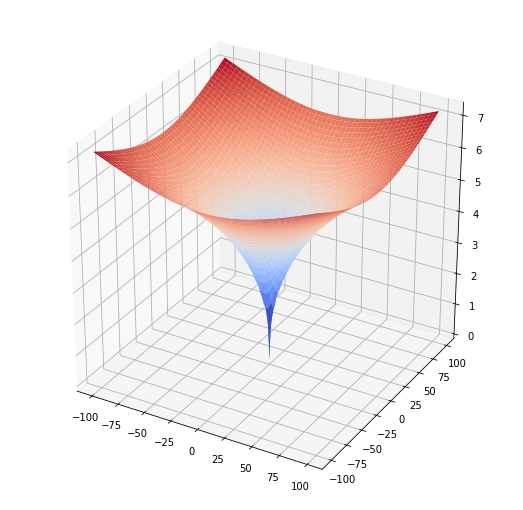

In [3]:
fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.gca(projection='3d')

X, Y = np.arange(-100, 100, 1), np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)
Z = (X**2 + Y**2)**(1.0/5.0)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1, antialiased=True)

## Defining a stochastic UDP (User Defined Problem)
Let us define a UDP that represents the above landscape adding the noise. 

In [4]:
class stprob:
    def __init__(self, dim = 2, seed = np.random.randint(123456789), sample_size = 10):
        self.dim = dim
        self.seed = seed
        self.sample_size = sample_size

    # Mandatory method for pagmo UDPs
    def fitness(self, x):
        # the state of the random number generator needs to correspond to the current seed
        np.random.seed(self.seed)
        noise = sum(np.random.normal(0,1,self.sample_size)) / self.sample_size
        objfun = sum([xi**2 for xi in x])**(1.0/5.0)
        return [objfun + noise]
    
    # Mandatory method for pagmo UDPs
    def get_bounds(self):
        return ([-100] * self.dim, [100] * self.dim)
    
    # Optional method for pagmo UDPs
    def get_name(self):
        return "Stochastic test problem"

    # Mandatory method for pagmo stochastic UDPs
    def set_seed(self, seed):
        self.seed = seed

    def get_extra_info(self):
        s = "\tDimension: {}\n".format(self.dim)
        s += "\tSeed: {}\n".format(self.seed)
        s += "\tSample size: {}\n".format(self.sample_size)
        return s

Now the landscape will look much more rugged and its shape will depend on the seed:

In [5]:
dim, sample_size = 2, 100
seed = 889
udp = stprob(dim, seed, sample_size)

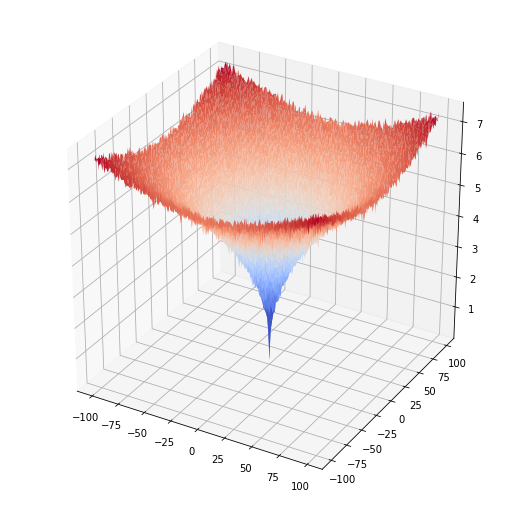

In [6]:
fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.gca(projection='3d')

X, Y = np.arange(-100, 100, 1), np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)
for (x, y), v in np.ndenumerate(X):
    Z[x,y] = udp.fitness([X[x,y], Y[x,y]])[0]
    # evaluate each point with a different random perturbation
    udp.set_seed(np.random.randint(12345678))
    
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1, antialiased=True)

This shows the fitness landscape an optimizer would explore during **one** generation only. Each following generation will have to deal with another distorted version as the seed will change (UDAs that deal with stochastic algorithms make sure that is the case). 

We will first generate a $d = 10$ variant for benchmarking:

In [7]:
dim, sample_size = 10, 100
seed = 889
udp = stprob(dim, seed, sample_size)
prob = pg.problem(udp)

There are a couple of algorithms already in pygmo that are able to optimize stochastic problems. We will instantiate 4 of them, give them enough time and compare their performance:

In [8]:
gens, popsize = 5000, 50

In [9]:
fit, cpu_times, best_xs = [], [], []
for uda in [pg.pso_gen(gens),
            pg.sga(gens, mutation='gaussian', param_m = 0.01),
            pg.cmaes(gens, xtol = 0.0, ftol= 0.0),
            pg.sea(gens)]:
    alg = pg.algorithm(uda)
    alg.set_verbosity(10)
    pop = pg.population(prob, popsize)
    t = time()
    pop = alg.evolve(pop)
    cpu_times.append(time() - t)
    log = alg.extract(type(uda)).get_log()
    # the fitness is included in the 2nd column of each log
    fit.append([line[2] for line in log])
    best_xs.append(pop.get_x()[pop.best_idx()])

In [10]:
labels = ['GPSO', 'SGA', 'CMAES', '(N+1)-ES']
generations = np.arange(0,gens, 10)

We plot the change in fitness over time:

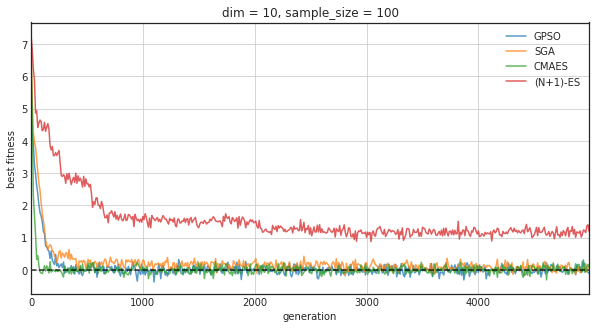

In [11]:
with plt.style.context(('seaborn-white')):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,5)
    for f in fit:
        ax.plot(generations, f, alpha = 0.75)
    ax.plot([0, max(generations)], [0,0], 'k--', alpha = 0.8)
    ax.set_xlabel('generation')
    ax.set_ylabel('best fitness')
    ax.set_xlim([0, max(generations)])
    ax.set_title('dim = {}, sample_size = {}'.format(dim, sample_size))
    ax.grid()
    ax.legend(labels)

The best spot to live in this stochastic landscape is still at zero. We check how close each algorithm came to this point:

In [12]:
opt = np.zeros(dim)
print('Distance to optimum:')
for x, label in zip(best_xs, labels):
    dist = np.linalg.norm(x)
    print('\t{0}: {1:0.2e}'.format(label, dist))   

Distance to optimum:
	GPSO: 3.65e-42
	SGA: 1.30e-03
	CMAES: 1.89e-44
	(N+1)-ES: 1.46e+00


In [13]:
print('CPU-time')
for t, label in zip(cpu_times, labels):
    print('\t{0}: {1:0.2e}'.format(label, t)) 

CPU-time
	GPSO: 2.30e+01
	SGA: 2.29e+01
	CMAES: 1.19e+01
	(N+1)-ES: 1.16e+01


The differences between the algorithms become more apparent if $d$ increases from $10$ to $100$:

In [14]:
dim, sample_size = 100, 100
seed = 889
udp = stprob(dim, seed, sample_size)

In [15]:
prob = pg.problem(udp)

In [16]:
gens, popsize = 5000, 50

In [17]:
fit, cpu_times, best_xs = [], [], []
for uda in [pg.pso_gen(gens),
            pg.sga(gens, mutation='gaussian', param_m = 0.01),
            pg.cmaes(gens, xtol = 0.0, ftol= 0.0),
            pg.sea(gens)]:
    alg = pg.algorithm(uda)
    alg.set_verbosity(10)
    pop = pg.population(prob, popsize)
    t = time()
    pop = alg.evolve(pop)
    cpu_times.append(time() - t)
    log = alg.extract(type(uda)).get_log()
    # the fitness is included in the 2nd column of each log
    fit.append([line[2] for line in log])
    best_xs.append(pop.get_x()[pop.best_idx()])

In [18]:
labels = ['GPSO', 'SGA', 'CMAES', '(N+1)-ES']
generations = np.arange(0,gens, 10)

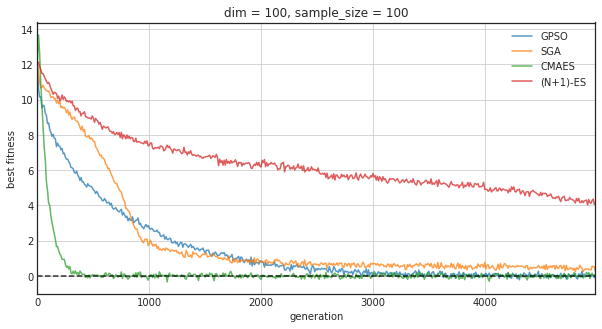

In [19]:
with plt.style.context(('seaborn-white')):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,5)
    for f in fit:
        ax.plot(generations, f, alpha = 0.75)
    ax.plot([0, max(generations)], [0,0], 'k--', alpha = 0.8)
    ax.set_xlabel('generation')
    ax.set_ylabel('best fitness')
    ax.set_xlim([0, max(generations)])
    ax.set_title('dim = {}, sample_size = {}'.format(dim, sample_size))
    ax.grid()
    ax.legend(labels)

In [20]:
opt = np.zeros(dim)
print('Distance to optimum:')
for x, label in zip(best_xs, labels):
    dist = np.linalg.norm(x)
    print('\t{0}: {1:0.2e}'.format(label, dist))

Distance to optimum:
	GPSO: 3.19e-05
	SGA: 1.12e-01
	CMAES: 2.16e-42
	(N+1)-ES: 3.63e+01


In [21]:
print('CPU-time')
for t, label in zip(cpu_times, labels):
    print('\t{0}: {1:0.2e}'.format(label, t))

CPU-time
	GPSO: 4.29e+01
	SGA: 4.22e+01
	CMAES: 1.25e+02
	(N+1)-ES: 2.11e+01
